In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import e
from cycler import cycler
plt.style.use('ggplot')

np.random.seed(42)
%matplotlib inline

# Laplace

- Higher epsilon == LESS privacy
- Higher scale == MORE privacy 
- Higher sensitivity == MORE privacy

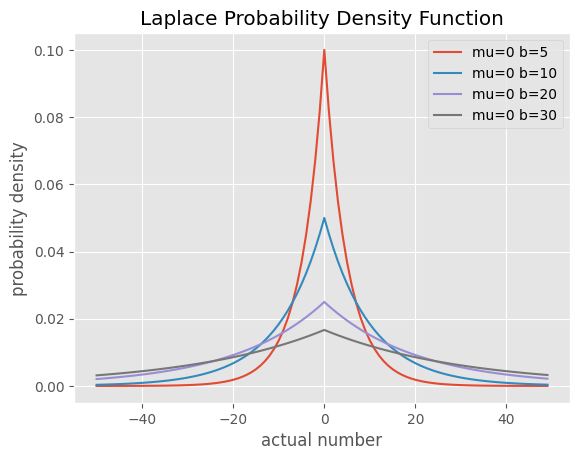

In [3]:
mu = [0, 0, 0, 0] # mean
b = [5, 10, 20, 30] # scale
linestyle_cycler = cycler('linestyle',['-','--',':','-.'])

x = np.arange(-50., 50., 1)
fig,ax= plt.subplots()
plt.rc('axes', prop_cycle=linestyle_cycler)

for mu_val, b_val in zip(mu, b):
    pdf = np.exp(-abs(x-mu_val)/b_val)/(2.*b_val)
    ax.plot(x, pdf, label='mu=%s b=%s' % (mu_val, b_val))
    
ax.set_title('Laplace Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density')
ax.set_prop_cycle(linestyle_cycler)
ax.legend()

Laplace scale: 1.0


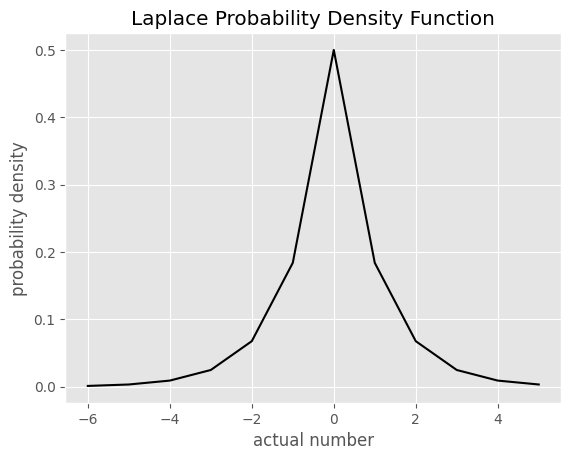

In [13]:
epsilon = 1 # higher is less privacy
p_u = 1 # maximum number of contributions / sensitivity
scale = p_u / epsilon
print("Laplace scale:", scale)

loc = 0

x = np.arange(-6., 6., 1) # -6 and 6 are bounds
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)

fig,ax= plt.subplots()
ax.plot(x, pdf, linestyle='-');
ax.set_title('Laplace Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density');

## Sensitivity & clamps

https://desfontain.es/privacy/differential-privacy-in-practice.html

### Clamps

What happens if that judgment call is wrong, and a user later decides to post 10 complaints in one day? To preserve the desired level of privacy, you need to clamp all values to the estimated maximum. In other words, for this outlier user, you would only count 5 complaints in the non-noisy sum.

...

Let's say each of your users gives your customer service a rating, between -10 and 10. You want to release the average rating. Computing an average is pretty much the same as computing a sum — add all ratings, then divide by the number of users1. So, what do we do to the sum to achieve differential privacy?

Among all rating options, we only have to consider the worst possible case. How far can the two noise curves be from each other? If the values are all between -10 and 10, the greatest possible difference is 10−(−10)=20. It happens when the attacker tries to determine whether a user voted -10 or 10.

Like in the previous example, you have to add noise of Laplace(20/ε) to get ε-differential privacy. And just as before, you need to check that each value is between your theoretical minimum and maximum. If you find an anomalous value, e.g. lower than the minimum, you need to clamp it to the minimum before adding it to the sum.

In some cases, estimating these minimum or maximum values is difficult. For example, if you're computing the average salary in a large group of people, how should you estimate the upper salary limit? I don't see that problem as a usability flaw of differential privacy. Rather, it suggests that averages are not a meaningful metric in the presence of outliers. Removing these outliers is a good idea for both accuracy and privacy :-)

### Sensitivity
For each type of specialized physician, we count the people who consulted with one. But we won't consider this histogram as 50 different counting queries. Instead, we'll consider it as a single function, with values in ℕ50. It outputs a vector: a list of 50 coordinates, each of which corresponds to a fixed specialty. How to make such a function f differentially private? We'll add noise, scaled by the function's sensitivity.

The **sensitivity of a function measures how much its output can change when you add one record in the database**. If the function returns a single number, we measure the absolute value of the difference: the sensitivity of f is the maximum value of ∣∣f(D1)−f(D2)∣∣.

In [5]:
def bound_list(input_list, min_value, max_value): 
    return [max(min(x, max_value), min_value) for x in input_list]

def laplace_dp_mechanism(value, epsilon, sensitivity = 1): # higher sensitivity is more privacy
    orig_value = value
    value =  np.random.laplace(value, sensitivity/epsilon)
    print("Noise: {}".format(value - orig_value))
    return value

In [6]:
ages = [round(np.random.normal(45,10)) for _ in range(100)]
bounded_ages = bound_list(ages, 20, 70) 

In [7]:
epsilon_for_sum = 0.5
epsilon_for_count = 0.5

summed_ages = laplace_dp_mechanism(np.sum(bounded_ages), epsilon_for_sum, sensitivity=50) # 1 entry can change sum age by 50 max
count_ages = laplace_dp_mechanism(len(bounded_ages), epsilon_for_count, sensitivity=1) # 1 entry can change count by 1 max

private_average_age = summed_ages / count_ages

Noise: -18.053674296511417
Noise: -1.6228904033606


In [8]:
print("Private average age:", private_average_age)
print("Actual average age:", np.mean(ages))
print("Error:", (private_average_age - np.mean(ages))/ np.mean(ages))

Private average age: 44.53217159627897
Actual average age: 43.98
Error: 0.012555061306934383
